##  Image to Avatar Generation

##### Objectives

- Preprocess and condition images for generation tasks

- Apply Stable Diffusion's img2img pipeline for stylistic avatar generation

- Evaluate generation quality using both identity preservation and style matching metrics

In [1]:
# %pip install torch-fidelity
# %pip install torchmetrics
# %pip install onnxruntime
# %pip install torch==2.1.2 torchvision==0.16.2 torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install diffusers==0.24.0 transformers==4.39.3 accelerate==0.27.2 safetensors==0.4.2
# %pip install huggingface_hub==0.19.4 insightface numpy==1.26.4

In [2]:
from diffusers import StableDiffusionImg2ImgPipeline
from transformers import CLIPProcessor, CLIPModel

# If both lines work without error, you're ready to run the tutorial
print("🎉 All dependencies are correctly installed!")


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


🎉 All dependencies are correctly installed!


In [3]:
import os
import requests
from PIL import Image
from io import BytesIO

os.makedirs("ffhq_100", exist_ok=True)
os.makedirs("ffhq_100_pixar", exist_ok=True)
os.makedirs("ffhq_100_Ghibli", exist_ok=True)

base_url = "https://huggingface.co/datasets/marcosv/ffhq-dataset/resolve/main/Part1/"

# for i in range(100):
#     file_name = f"{i:05d}.png"
#     response = requests.get(base_url + file_name)
#     if response.status_code == 200:
#         img = Image.open(BytesIO(response.content)).convert("RGB")
#         img.save(f"ffhq_100/{file_name}")

def get_prompt_from_version(prompt_version):
    if prompt_version == "Ghibli":
        prompt = "A Studio Ghibli-style portrait that closely resembles the original person, soft lighting, gentle colors, 2D anime-style illustration"
    else:
        prompt = "Pixar-style character portrait, clean features, cute and friendly expression, high quality digital art"
    return prompt


#### Step 2: Avatar Generation Using Stable Diffusion Img2Img

In [4]:
from diffusers import StableDiffusionImg2ImgPipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cpu")

from PIL import Image
import matplotlib.pyplot as plt
import os


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


In [5]:
def generate_avatars_and_plot(num_pairs: int, prompt_version=None):

    prompt = get_prompt_from_version(prompt_version)
    raw_paths = [f"ffhq_100/{i:05d}.png" for i in range(num_pairs)]
    raw_images = []
    avatar_images = []

    for i, path in enumerate(raw_paths):
        if not os.path.exists(path):
            print(f"[WARNING] Missing input image: {path}")
            continue

        init_image = Image.open(path).convert("RGB").resize((512, 512))
        raw_images.append(init_image)

        result = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images[0]
        avatar_images.append(result)

        result.save(f"ffhq_100_{prompt_version}/avatar_{i}.png")
        print(f"[INFO] Saved: avatar_{i}.png")


#### Step 3: Metrics evaluation (FID, CLIPScore, Identity Similarity)

In [17]:
import os
import json
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

from transformers import CLIPProcessor, CLIPModel
from insightface.app import FaceAnalysis
from torchmetrics.image.fid import FrechetInceptionDistance

# ---------- Helper: Convert PIL image to uint8 tensor for FID ----------
def pil_to_uint8_tensor(img_pil, size=(299, 299)):
    img_resized = img_pil.resize(size)
    return torch.from_numpy(np.array(img_resized)).permute(2, 0, 1).to(torch.uint8)

def is_dark_image(pil_image, threshold=10):
    # Convert to grayscale and compute mean pixel intensity
    gray = pil_image.convert("L")
    mean_pixel = np.array(gray).mean()
    return mean_pixel < threshold

def evaluate_avatar_generation(num_pairs: int, prompt_version=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Using device: {device}")

    prompt = get_prompt_from_version(prompt_version)

    # Identity model
    face_app = FaceAnalysis(name="buffalo_l")
    face_app.prepare(ctx_id=0 if torch.cuda.is_available() else -1)

    # CLIP model
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # FID model
    fid = FrechetInceptionDistance(feature=2048).to(device)

    results = []
    skipped_count = 0

    def is_dark_image(pil_image, threshold=10):
        gray = pil_image.convert("L")
        mean_pixel = np.array(gray).mean()
        return mean_pixel < threshold

    for i in tqdm(range(num_pairs)):
        raw_path = f"ffhq_100/{i:05d}.png"
        avatar_path = f"ffhq_100_{prompt_version}/avatar_{i}.png"

        if not os.path.exists(raw_path):
            print(f"[DEBUG] Raw image not found: {raw_path}")
            continue
        if not os.path.exists(avatar_path):
            print(f"[DEBUG] Avatar image not found: {avatar_path}")
            continue

        try:
            img_raw = Image.open(raw_path).convert("RGB")
            img_avatar = Image.open(avatar_path).convert("RGB")

            if is_dark_image(img_avatar):
                print(f"[WARNING] Skipping dark avatar image: {avatar_path}")
                skipped_count += 1
                continue

            print(f"[INFO] Processing pair {i}:")
            print(f"       Raw: {raw_path}")
            print(f"       Avatar: {avatar_path}")

            # Identity Similarity
            raw_feats = face_app.get(np.array(img_raw))
            avatar_feats = face_app.get(np.array(img_avatar))
            if not raw_feats or not avatar_feats:
                identity_sim = None
            else:
                identity_sim = cosine_similarity(
                    [raw_feats[0].embedding],
                    [avatar_feats[0].embedding]
                )[0][0]

            # CLIPScore
            inputs = clip_processor(
                text=prompt,
                images=img_avatar,
                return_tensors="pt",
                padding=True
            ).to(device)
            outputs = clip_model(**inputs)
            clip_score = torch.cosine_similarity(
                outputs.text_embeds, outputs.image_embeds
            )[0].item()

            # FID
            raw_tensor = pil_to_uint8_tensor(img_raw).unsqueeze(0).to(device)
            avatar_tensor = pil_to_uint8_tensor(img_avatar).unsqueeze(0).to(device)
            fid.update(raw_tensor, real=True)
            fid.update(avatar_tensor, real=False)

            res_cur = {
                "index": i,
                "identity_similarity": identity_sim,
                "clip_score": clip_score,
                "raw_path": raw_path,
                "avatar_path": avatar_path
            }
            print(res_cur)
            results.append(res_cur)

        except Exception as e:
            print(f"[ERROR] Failed at index {i}: {e}")
            skipped_count += 1

    fid_score = fid.compute().item()

    output = {
        "metrics": results,
        "summary": {
            "fid": fid_score,
            "identity_mean": np.mean([
                r["identity_similarity"] for r in results if r["identity_similarity"] is not None
            ]),
            "clipscore_mean": np.mean([r["clip_score"] for r in results]),
            "excluded_dark_or_invalid": skipped_count,
        }
    }

    with open(f"avatar_metrics_{prompt_version}.json", "w") as f:
        def convert(o):
            if isinstance(o, (np.float32, np.float64, np.int32, np.int64)):
                return float(o)
            raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")
        json.dump(output, f, indent=2, default=convert)

    print(f"\n✅ Evaluation complete. {skipped_count} images excluded. Results saved to avatar_metrics_{prompt_version}.json")


In [11]:
# ---------- Run Style Transfer and Evaluation ----------
num_pairs = 100
prompt_version = "pixar"

generate_avatars_and_plot(num_pairs=num_pairs, prompt_version= prompt_version)
evaluate_avatar_generation(num_pairs=num_pairs, prompt_version= prompt_version)


 14%|█▎        | 5/37 [00:46<04:31,  8.49s/it]

[INFO] Saved: avatar_0.png
[INFO] Saved: avatar_1.png
[INFO] Saved: avatar_2.png
[INFO] Saved: avatar_3.png
[INFO] Saved: avatar_4.png
[INFO] Saved: avatar_5.png
[INFO] Saved: avatar_6.png


In [18]:
prompt_version = "pixar"

evaluate_avatar_generation(num_pairs=num_pairs, prompt_version= prompt_version)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/azureuser/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/azureuser/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/azureuser/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/azureuser/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/azureuser/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112]

  3%|▎         | 3/100 [00:03<02:32,  1.57s/it]/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
Unused or unrecognized kwargs: padding.
  4%|▍         | 4/100 [00:05<02:34,  1.61s/it]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future

/tmp/ipykernel_3010/2099532629.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.05, hspace=0.25)  # Smaller width space between columns


✅ Saved plot to avatar_grid_pixar_vs_ghibli.png


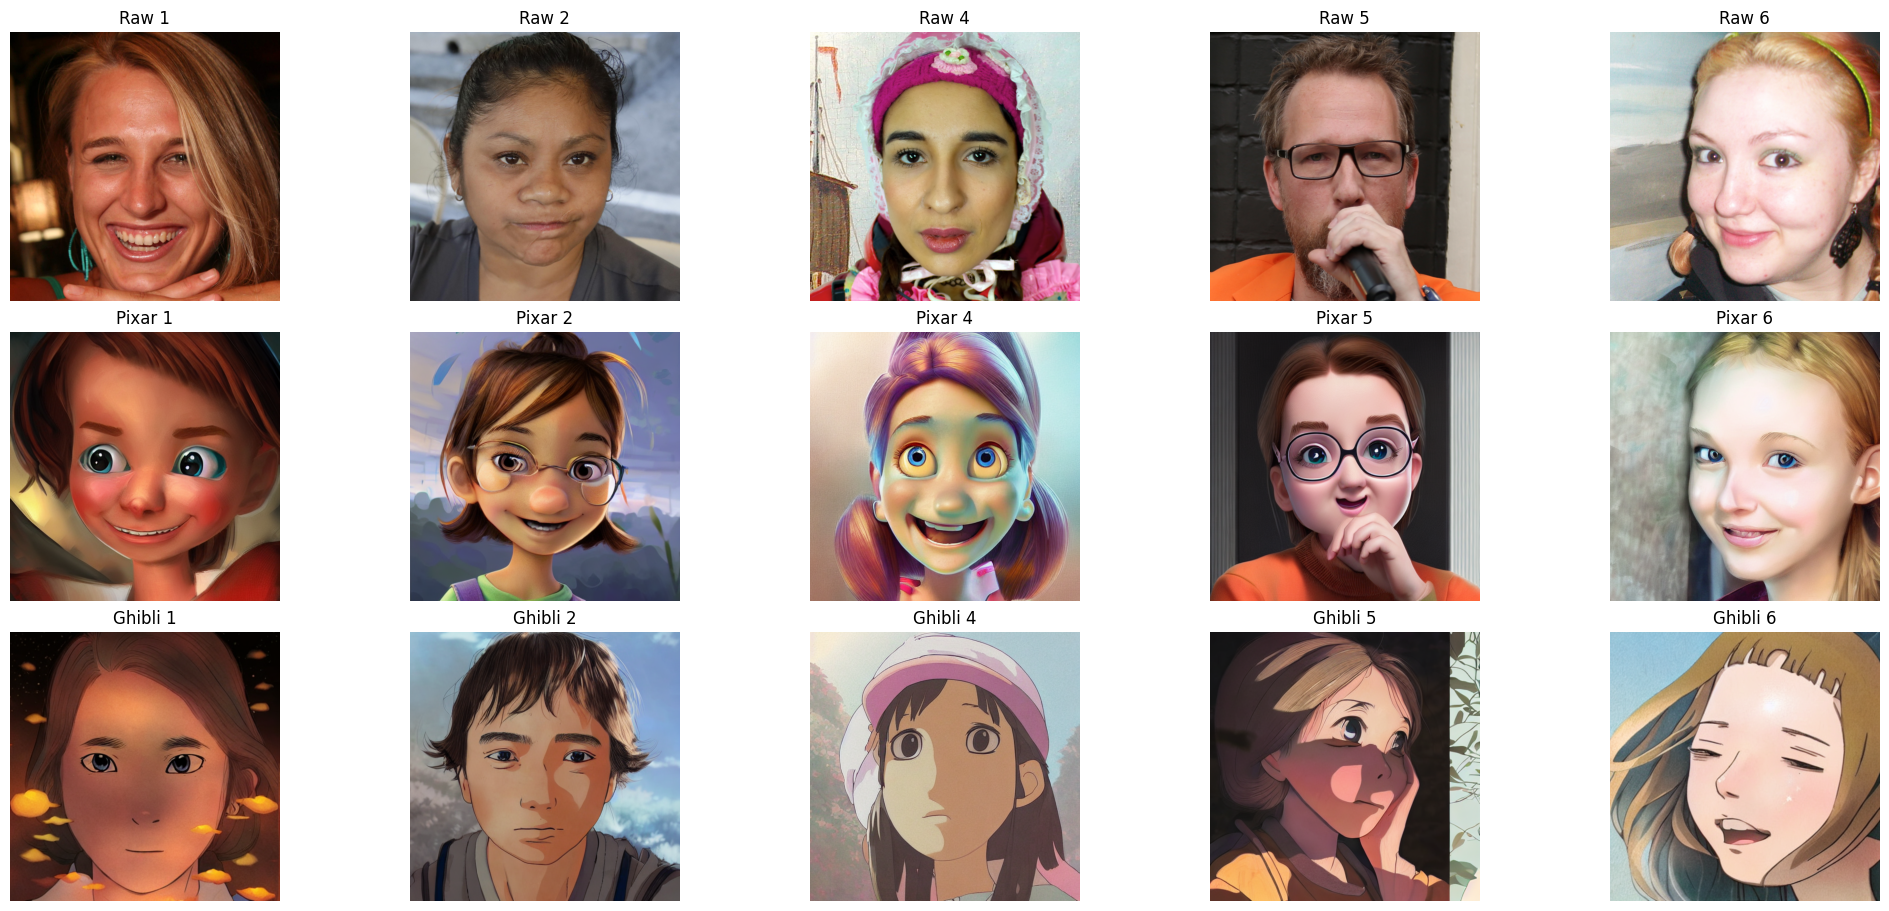

In [24]:
import matplotlib.pyplot as plt
from PIL import Image

def open_image_from_path(path):
    return Image.open(path).convert("RGB").resize((512, 512))

# Select 4 indices to visualize
image_indices = [1, 2, 4,5,6]

raw_images = [open_image_from_path(f"ffhq_100/{i:05d}.png") for i in image_indices]
avatar_images_pixar = [open_image_from_path(f"ffhq_100_pixar/avatar_{i}.png") for i in image_indices]
avatar_images_ghibli = [open_image_from_path(f"ffhq_100_Ghibli/avatar_{i}.png") for i in image_indices]

# Plot and save
num_pairs_plt = len(image_indices)
fig, axs = plt.subplots(3, num_pairs_plt, figsize=(4 * num_pairs_plt, 9), constrained_layout=True)

for i in range(num_pairs_plt):
    axs[0, i].imshow(raw_images[i])
    axs[0, i].set_title(f"Raw {image_indices[i]}", fontsize=12)
    axs[0, i].axis("off")

    axs[1, i].imshow(avatar_images_pixar[i])
    axs[1, i].set_title(f"Pixar {image_indices[i]}", fontsize=12)
    axs[1, i].axis("off")

    axs[2, i].imshow(avatar_images_ghibli[i])
    axs[2, i].set_title(f"Ghibli {image_indices[i]}", fontsize=12)
    axs[2, i].axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.25)  # Smaller width space between columns
plt.savefig("avatar_grid_pixar_vs_ghibli.png", dpi=200)
print("✅ Saved plot to avatar_grid_pixar_vs_ghibli.png")
plt.show()
